In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import numpy as np
import matplotlib.pyplot as plt

from dataset import CardiacDataset
from model import UNet

In [3]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15),
              rotate=(-45, 45)),
    iaa.ElasticTransformation()
])

In [4]:
train_path = Path("Preprocessed/train/")
val_path = Path("Preprocessed/val/")

train_dataset = CardiacDataset(train_path, seq)
val_dataset = CardiacDataset(val_path, None)

In [5]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [6]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, mask):
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred*mask).sum()
        denum = pred.sum() + mask.sum() + 1e-8
        dice = (2*counter) / denum
        return 1 - dice

In [7]:
class AtriumSegmentation(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = UNet()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = DiceLoss()
        
    def forward(self, data):
        return torch.sigmoid(self.model(data))
    
    def training_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Train Dice", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Train")
            
        return loss
    
    def validation_step(self, batch, batch_idx):
        mri, mask = batch
        mask = mask.float()
        pred = self(mri)
        
        loss = self.loss_fn(pred, mask)
        
        self.log("Val Dice", loss)
        
        if batch_idx % 2 == 0:
            self.log_images(mri.cpu(), pred.cpu(), mask.cpu(), "Val")
            
        return loss
    
    def log_images(self, mri, pred, mask, name):
        pred = pred > 0.5
        
        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(mask[0][0] == 0, mask[0][0])
        axis[0].imshow(mask_, alpha=0.6)
        
        axis[1].imshow(mri[0][0], cmap="bone")
        mask_ = np.ma.masked_where(pred[0][0] == 0, pred[0][0])
        axis[1].imshow(mask_, alpha=0.6)
        
    def configure_optimizers(self):
        return [self.optimizer]

In [8]:
torch.manual_seed(0)
model = AtriumSegmentation()

In [10]:
checkpoint_callback = ModelCheckpoint(monitor="Val Dice", save_top_k=10, mode="min")

In [11]:
trainer = pl.Trainer(gpus=1, logger=TensorBoardLogger(save_dir="logs"), log_every_n_steps=1,
                    callbacks=checkpoint_callback, max_epochs=75)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | UNet     | 7.8 M 
1 | loss_fn | DiceLoss | 0     
-------------------------------------
7.8 M     Trainable params
0         Non-trainable params
7.8 M     Total params
31.127    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/sabari/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/sabari/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
/home/sabari/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/sabari/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


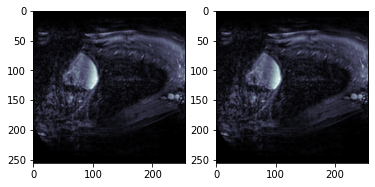

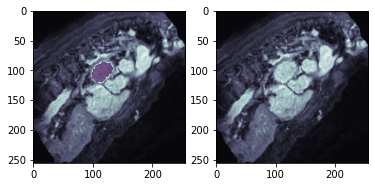

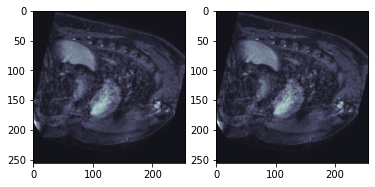

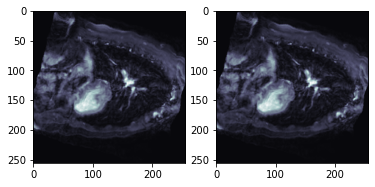

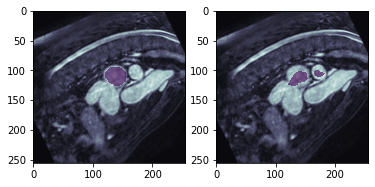

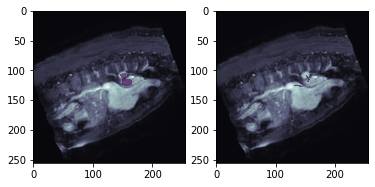

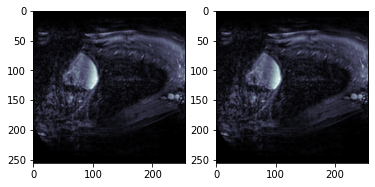

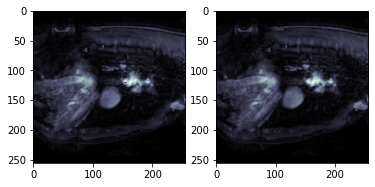

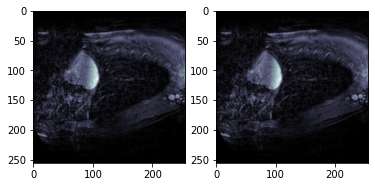

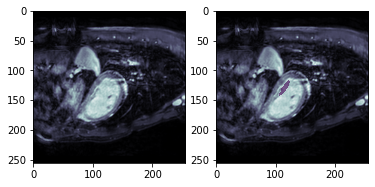

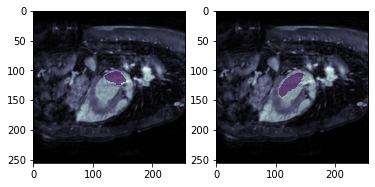

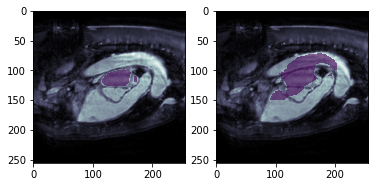

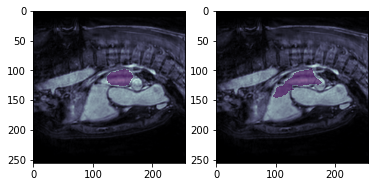

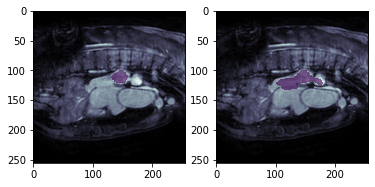

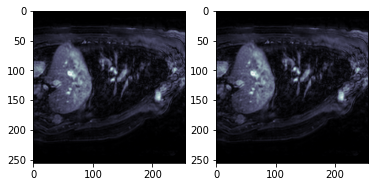

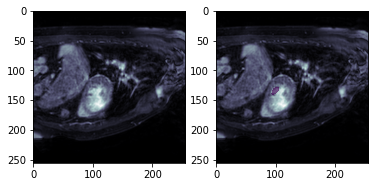

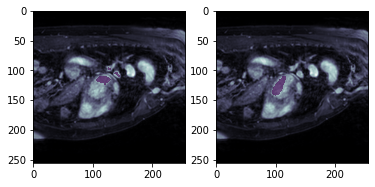

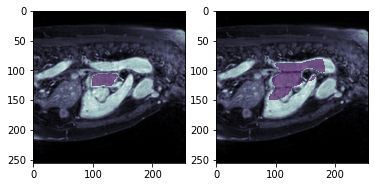

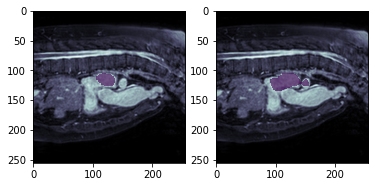

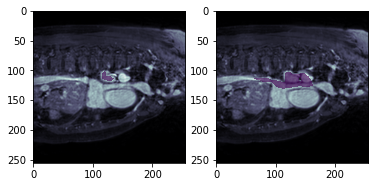

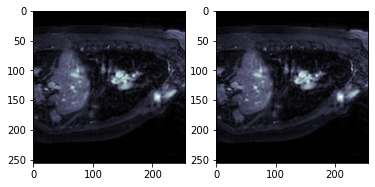

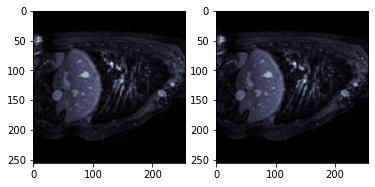

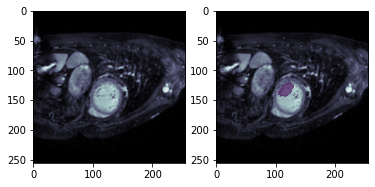

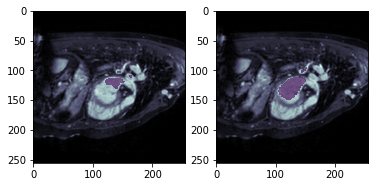

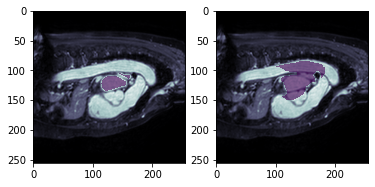

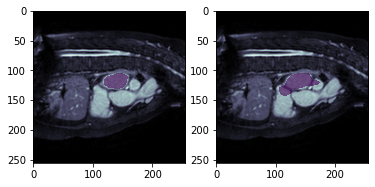

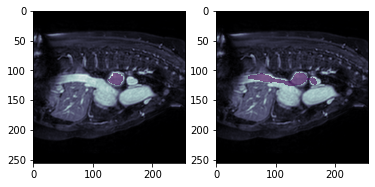

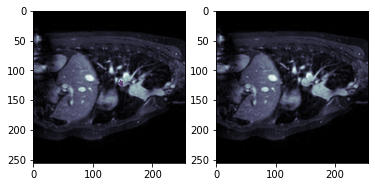

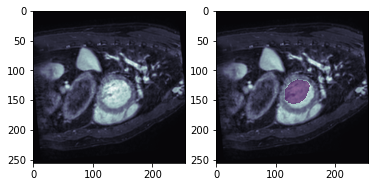

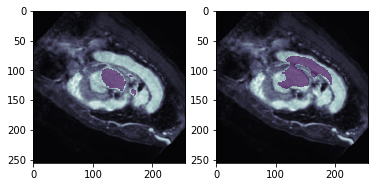

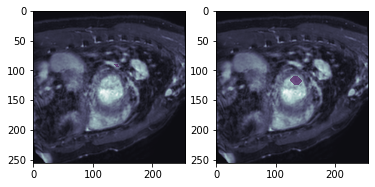

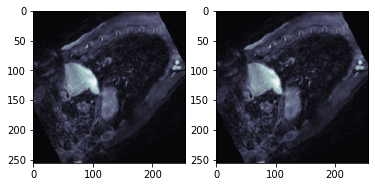

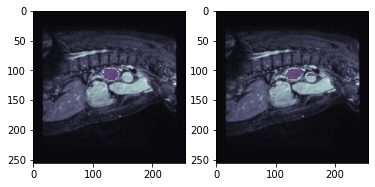

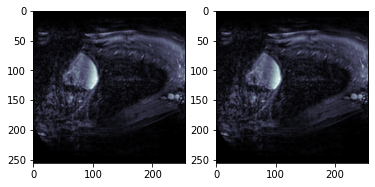

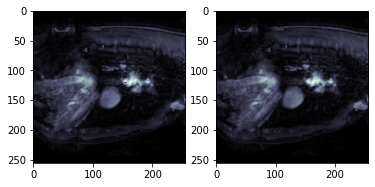

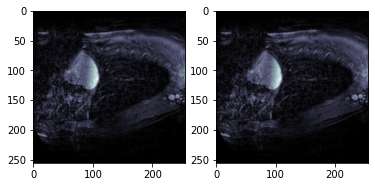

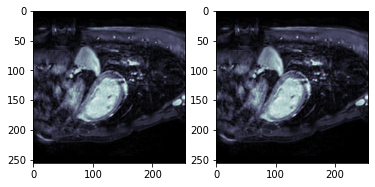

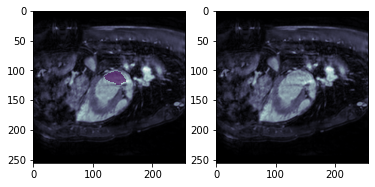

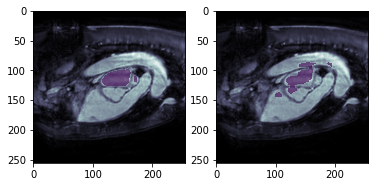

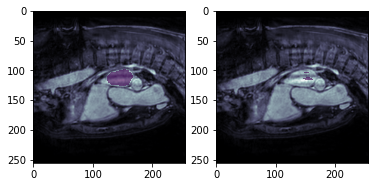

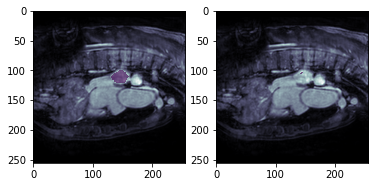

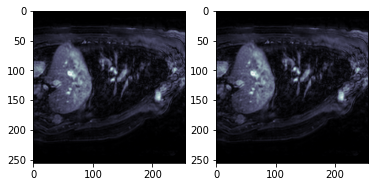

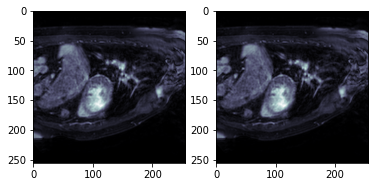

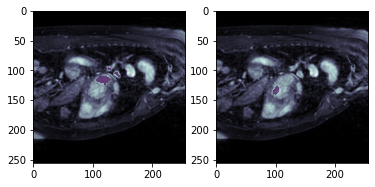

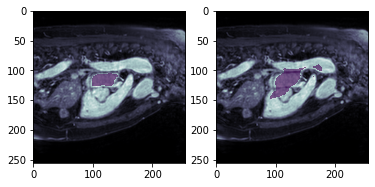

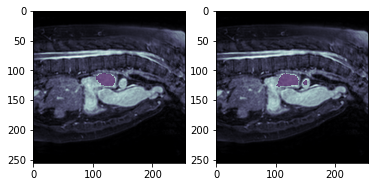

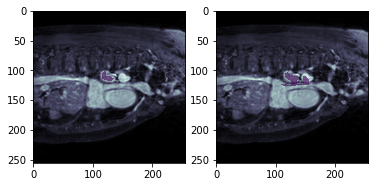

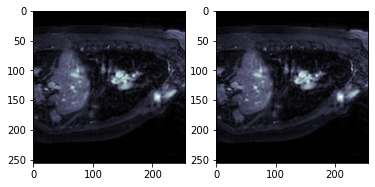

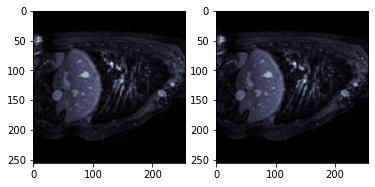

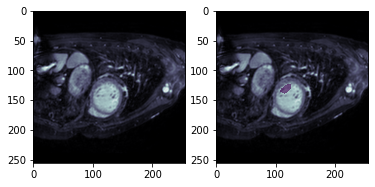

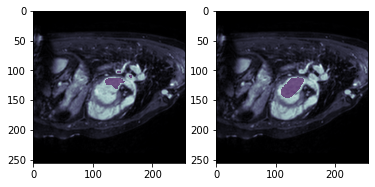

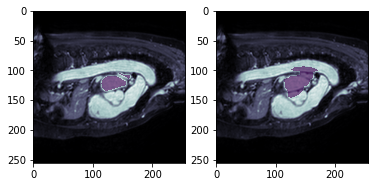

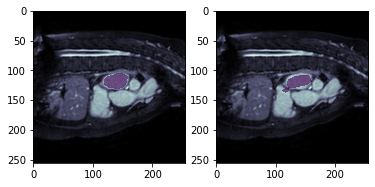

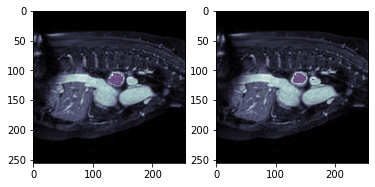

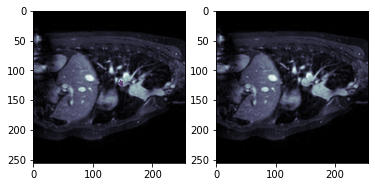

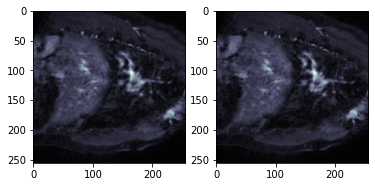

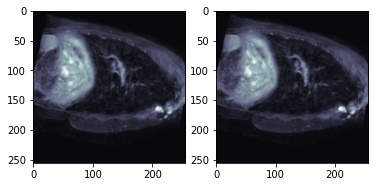

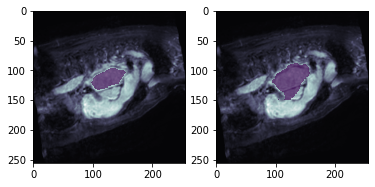

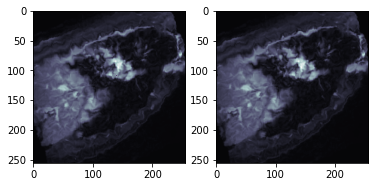

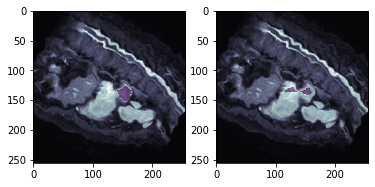

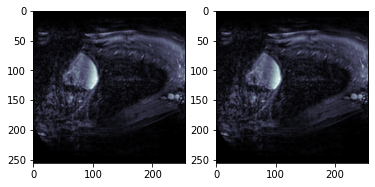

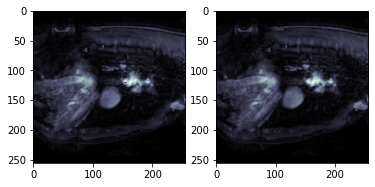

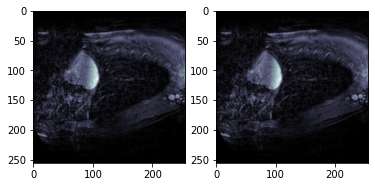

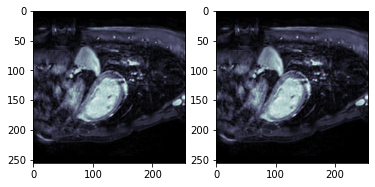

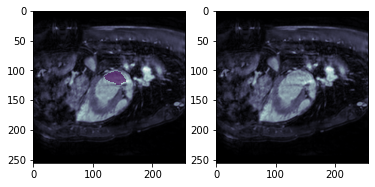

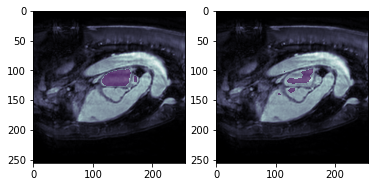

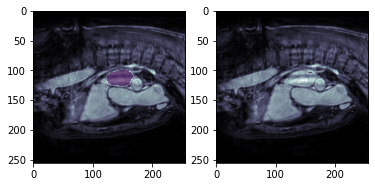

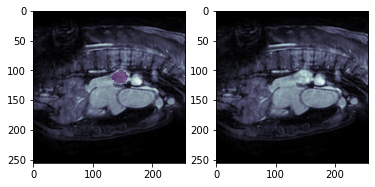

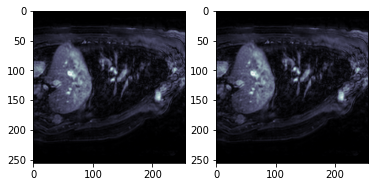

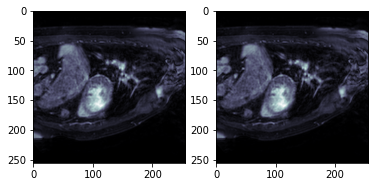

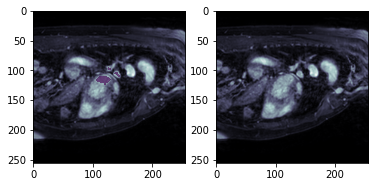

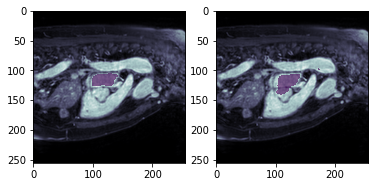

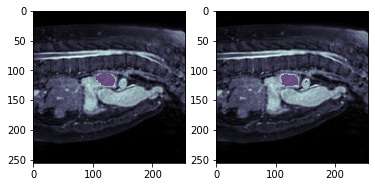

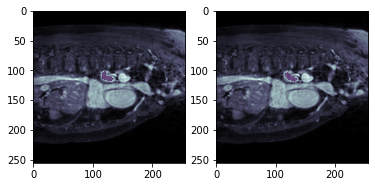

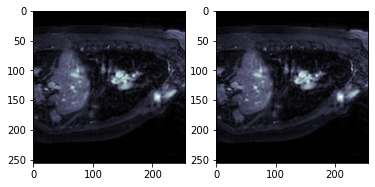

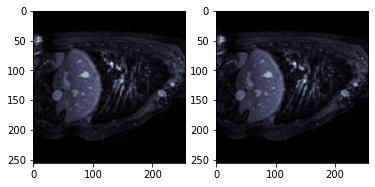

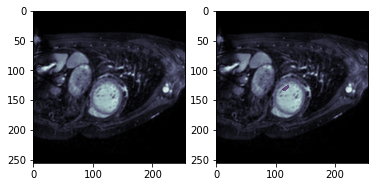

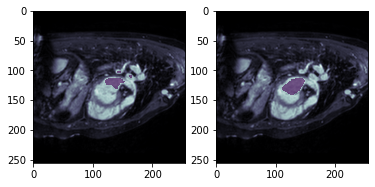

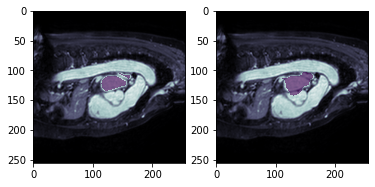

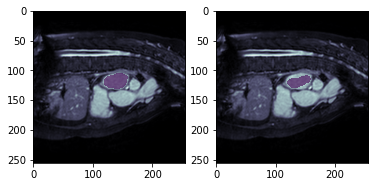

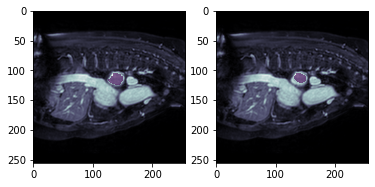

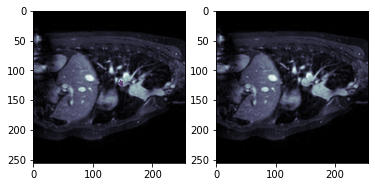

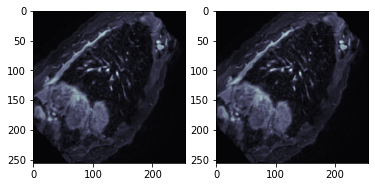

In [12]:
trainer.fit(model, train_loader, val_loader)

### Evaluation

In [9]:
import nibabel as nib
from tqdm.notebook import tqdm
from celluloid import Camera

In [10]:
pwd

'/mnt/c/Users/Gokul Sabari/Desktop/image_analysis/atrium_segmentation_workout'

In [11]:
model = AtriumSegmentation.load_from_checkpoint("/mnt/c/Users/Gokul Sabari/Desktop/image_analysis/06-Atrium-Segmentation/weights/70.ckpt")

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

AtriumSegmentation(
  (model): UNet(
    (layer1): DoubleConv(
      (step): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer2): DoubleConv(
      (step): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer3): DoubleConv(
      (step): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (layer4): DoubleConv(
      (step): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2):

In [14]:
preds = []
labels = []

for slices, label in tqdm(val_dataset):
    slices = torch.tensor(slices).to(device).unsqueeze(0)
    with torch.no_grad():
        pred = model(slices)
    preds.append(pred.cpu().numpy())
    labels.append(label)
preds = np.array(preds)
labels = np.array(labels)

  0%|          | 0/339 [00:00<?, ?it/s]

In [15]:
1 - model.loss_fn(torch.from_numpy(preds), torch.from_numpy(labels))

tensor(0.9539)

### Prediction

In [16]:
subject = "Task02_Heart/imagesTs/la_002.nii.gz"
subject_mri = nib.load(subject).get_fdata()

In [19]:
def normalize(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [23]:
subject_mri = subject_mri[32:-32, 32:-32]
standardized_scan = standardize(normalize(subject_mri))

In [24]:
preds = []
for i in range(standardized_scan.shape[-1]):
    slices = standardized_scan[:, :, i]
    with torch.no_grad():
        pred = model(torch.tensor(slices).unsqueeze(0).unsqueeze(0).float().to(device))[0][0]
        pred = pred > 0.5
    preds.append(pred.cpu())

/home/sabari/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/sabari/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


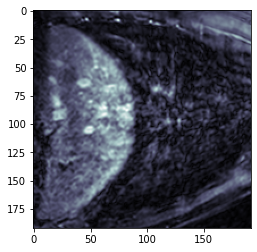

In [25]:
fig = plt.figure()
camera = Camera(fig)

for i in range(standardized_scan.shape[-1]):
    plt.imshow(standardized_scan[:, :, i], cmap="bone")
    mask = np.ma.masked_where(preds[i] == 0, preds[i])
    plt.imshow(mask, alpha=0.5)
    camera.snap()
animation = camera.animate()

In [26]:
from IPython.display import HTML
HTML(animation.to_html5_video())

/home/sabari/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/sabari/miniconda3/envs/pytorchenv/lib/python3.7/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2
